# fast.torch
This should be a template for training self-supervised models using PyTorch and fastai. 

In [1]:
from enum import Enum
from pathlib import Path
import sys
sys.path.append('../')
sys.path.append('../../../model')

from metrics import *
from data import EMPSSR
from utils import show_sample, show_result, get_pssr_transforms


import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastprogress.fastprogress import master_bar, progress_bar

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def save(model_name):
    save_pth = model_pth/model_kind/(model_name+'.pkl')
    torch.save(model.state_dict(), save_pth)
    print(f'Model saved: {model_name}')

def get_ds(bs, size, c=1, sample=False):
    train_set = pd.read_csv('../train.csv')
    valid_set = pd.read_csv('../valid.csv')
    if sample:
        train_set = train_set.sample(frac=0.1)
        valid_set = valid_set.sample(frac=0.1)
    tfms = get_pssr_transforms(size)
    train_ds = EMPSSR(train_set, c, tfms)
    valid_ds = EMPSSR(valid_set, c, tfms)
    return train_ds, valid_ds

In [3]:
train_set = pd.read_csv('../train.csv')
valid_set = pd.read_csv('../valid.csv')

In [4]:
bs = 64  # batch size
size = 128  # image size
tfms = get_pssr_transforms(128)
train_ds, valid_ds = get_ds(bs, size)

In [5]:
db = DataBunch.create(train_ds, valid_ds)

In [6]:
gpu_id = 3
loss_function = F.mse_loss
model_kind = 'baseline/'

In [7]:
torch.cuda.set_device(gpu_id)
num_cores = 4
arch = models.resnet34
wd = 1e-3
superres_metrics = [F.mse_loss, psnr, ssim]
model_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/models/self_sv/')

# Error!

the learner is using the size of an input to decide how to connect the decoder to the encoder, but here the size is expected to be a `fastai.vision.image.Image`.size instead of a `torch.Tensor`**.size()** which is why it's a built-in method

In [8]:
# %debug
learn = unet_learner(db, arch, wd=wd, 
                         loss_func=loss_function,
                         metrics=superres_metrics, 
                         blur=False, 
                         norm_type=NormType.Weight, 
                         model_dir=model_pth/model_kind)

TypeError: new() argument after * must be an iterable, not builtin_function_or_method

## TRAINING

In [4]:
train_date = '5.2'

## Round 1

In [ ]:
bs = 64  # batch size
size = 128  # image size
train_dl, valid_dl = get_loaders(bs, size)
model = DynamicUnet(encoder, n_classes=1,
                    img_size=(size,size), norm_type=nt.Weight)
## 1a
lrs, moms = get_lrs(train_dl, max_lr=1e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=lrs[0], momentum=moms[0])
train(1)
## 1b
lrs, moms = get_lrs(train_dl, max_lr=1e-3, min_lr=1e-5)
optimizer = torch.optim.SGD(model.parameters(), lr=lrs[0], momentum=moms[0])
train(1)
##save&export
model_name = train_date + '_round_1'
save(model_name)

## Round 2

In [14]:
bs = 16  # batch size
size = 256  # image size
train_dl, valid_dl = get_loaders(bs, size)
encoder.cpu()
model = DynamicUnet(encoder, n_classes=1,
                    img_size=(size,size), norm_type=nt.Weight)
model.cuda()
model_name = '4.27_round_1'
model_kind = 'baseline/'
model_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/models/self_sv/')
save_pth = model_pth/model_kind/(model_name+'.pkl')
model.load_state_dict(torch.load(save_pth))

<All keys matched successfully>

In [15]:
## 2a
flattened = flatten_model(model)
freeze()
lrs, moms = get_lrs(train_dl, max_lr=1e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=lrs[0], momentum=moms[0])
train(3)
## 2b
unfreeze()
lrs, moms = get_lrs(train_dl, max_lr=1e-3, min_lr=1e-5)
optimizer = torch.optim.SGD(model.parameters(), lr=lrs[0], momentum=moms[0])
train(3)
##save&export
model_name = train_date + '_round_2'
save(model_name)

Training Model...
Epoch 1 Batch 1 loss: 6.117615383118391e-05
Epoch 1 Batch 101 loss: 0.005963706565089524
Epoch 1 Batch 201 loss: 0.005875241146422922
Epoch 1 Batch 301 loss: 0.0058029477251693605
Epoch 1 Batch 401 loss: 0.005743363401852548
Epoch 1 Batch 501 loss: 0.005707017150707543
Epoch 1 Batch 601 loss: 0.005673654354177415
Epoch 1 Batch 701 loss: 0.005624568080529571
Epoch 1 Batch 801 loss: 0.0055744366673752665
Epoch 1 Batch 901 loss: 0.005506794857792556
Epoch 1 Batch 1001 loss: 0.005524232573807239
Epoch 1 Batch 1101 loss: 0.005483966851606965
Epoch 1 Batch 1201 loss: 0.005390967796556651


KeyboardInterrupt: 

## Round 3

In [7]:
bs = 8  # batch size
size = 512  # image size
train_dl, valid_dl = get_loaders(bs, size, sample=True)
encoder.cpu()
model = DynamicUnet(encoder, n_classes=1,
                    img_size=(size,size), norm_type=nt.Weight)
model.cuda()

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [5]:
model_name = '4.27_round_2'
model_kind = 'baseline/'
model_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/models/self_sv/')
save_pth = model_pth/model_kind/(model_name+'.pkl')
model.load_state_dict(torch.load(save_pth))

<All keys matched successfully>

In [7]:
## 3a
flattened = flatten_model(model)
freeze()
lrs, moms = get_lrs(train_dl, max_lr=1e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=lrs[0], momentum=moms[0])
train(3)
## 3b
unfreeze()
lrs, moms = get_lrs(train_dl, max_lr=1e-4, min_lr=1e-5)
optimizer = torch.optim.SGD(model.parameters(), lr=lrs[0], momentum=moms[0])
train(3)
##save&export
model_name = train_date + '_round_3'
save(model_name)

Training Model...
Epoch 1 Batch 1 loss: 4.0317922830581666e-05
Epoch 1 Batch 101 loss: 0.0041832943144254385
Epoch 1 Batch 201 loss: 0.004205498688388615
Epoch 1 Batch 301 loss: 0.00420334632974118
Epoch 1 Batch 401 loss: 0.004197348370216787
Epoch 1 Batch 501 loss: 0.004188877181150019
Epoch 1 Batch 601 loss: 0.004164377157576382
Epoch 1 Batch 701 loss: 0.004227074712980538
Epoch 1 Batch 801 loss: 0.004135940403211862
Epoch 1 Batch 901 loss: 0.0041201293049380186
Validating Model...


Epoch 1, Train loss: 0.0042,
Valid loss:0.0041,
Valid psnr: 22.61,
Valid ssim: 0.4388
Training Model...
Epoch 2 Batch 1 loss: 0.0040834314655512575
Epoch 2 Batch 101 loss: 0.004123015378136188
Epoch 2 Batch 201 loss: 0.004133774286601693
Epoch 2 Batch 301 loss: 0.004151527041103691
Epoch 2 Batch 401 loss: 0.004214503630064428
Epoch 2 Batch 501 loss: 0.004209784567356109
Epoch 2 Batch 601 loss: 0.004144144020974636
Epoch 2 Batch 701 loss: 0.004129718525800854
Epoch 2 Batch 801 loss: 0.004110897188074887
Epoch 2 Batch 901 loss: 0.004169579625595361
Validating Model...


Epoch 2, Train loss: 0.0083,
Valid loss:0.0041,
Valid psnr: 22.62,
Valid ssim: 0.4391
Training Model...
Epoch 3 Batch 1 loss: 0.004095073796343059
Epoch 3 Batch 101 loss: 0.004172886968590319
Epoch 3 Batch 201 loss: 0.00412754945922643
Epoch 3 Batch 301 loss: 0.004146946717519313
Epoch 3 Batch 401 loss: 0.0041598313604481515
Epoch 3 Batch 501 loss: 0.004200859044212848
Epoch 3 Batch 601 loss: 0.004138350998982787
Epoch 3 Batch 701 loss: 0.004164697118103505
Epoch 3 Batch 801 loss: 0.004029379370622337
Epoch 3 Batch 901 loss: 0.004129886187147349
Validating Model...


Epoch 3, Train loss: 0.0125,
Valid loss:0.0041,
Valid psnr: 22.64,
Valid ssim: 0.4401


Training Model...
Epoch 1 Batch 1 loss: 3.957501612603664e-05
Epoch 1 Batch 101 loss: 0.004091365064959973
Epoch 1 Batch 201 loss: 0.004100350101944059
Epoch 1 Batch 301 loss: 0.004054282647557556
Epoch 1 Batch 401 loss: 0.0041106844530440865
Epoch 1 Batch 501 loss: 0.004150506784208119
Epoch 1 Batch 601 loss: 0.004101946942973882
Epoch 1 Batch 701 loss: 0.004154314682818949
Epoch 1 Batch 801 loss: 0.004113604766316712
Epoch 1 Batch 901 loss: 0.004110113305505365
Validating Model...


Epoch 1, Train loss: 0.0041,
Valid loss:0.0041,
Valid psnr: 22.65,
Valid ssim: 0.4419
Training Model...
Epoch 2 Batch 1 loss: 0.004163182326592505
Epoch 2 Batch 101 loss: 0.004100914299488068
Epoch 2 Batch 201 loss: 0.004150864037219435
Epoch 2 Batch 301 loss: 0.004170245919376612
Epoch 2 Batch 401 loss: 0.004121089053805918
Epoch 2 Batch 501 loss: 0.004087801864370704
Epoch 2 Batch 601 loss: 0.004084479962475598
Epoch 2 Batch 701 loss: 0.004111885828897357
Epoch 2 Batch 801 loss: 0.004092769746202976
Epoch 2 Batch 901 loss: 0.004158742655999958
Validating Model...


Epoch 2, Train loss: 0.0082,
Valid loss:0.0041,
Valid psnr: 22.65,
Valid ssim: 0.4413
Training Model...
Epoch 3 Batch 1 loss: 0.004065713072195649
Epoch 3 Batch 101 loss: 0.004074291607830674
Epoch 3 Batch 201 loss: 0.004100744172465056
Epoch 3 Batch 301 loss: 0.004162683105096221
Epoch 3 Batch 401 loss: 0.004116461600642651
Epoch 3 Batch 501 loss: 0.004146478488110006
Epoch 3 Batch 601 loss: 0.004052479714155197
Epoch 3 Batch 701 loss: 0.004087802995927632
Epoch 3 Batch 801 loss: 0.00410775258904323
Epoch 3 Batch 901 loss: 0.004168844271916896
Validating Model...


Epoch 3, Train loss: 0.0123,
Valid loss:0.0041,
Valid psnr: 22.64,
Valid ssim: 0.4399
Model saved: 4.29_round_3


### viz

In [11]:
train_set = pd.read_csv('../train.csv')
valid_set = pd.read_csv('../valid.csv')
tfms = get_pssr_transforms(size)
train_ds = EMPSSR(train_set, tfms)
valid_ds = EMPSSR(valid_set, tfms)

In [17]:
model_name = '4.27_round_3'
model_kind = 'baseline/'
model_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/models/self_sv/')
save_pth = model_pth/model_kind/(model_name+'.pkl')

In [18]:
model.load_state_dict(torch.load(save_pth))

<All keys matched successfully>

In [20]:
from fastai.vision import *

In [ ]:
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/')
lr_path = f'EM/training/trainsets/lr/'
hr_path = f'EM/training/trainsets/hr/'

# helper func
lr = 1e-3
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)

# loading 3 rounds of data
bs_1 = 64
size_1 = 128
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_1, in_sz=size_1, out_sz=size_1, max_zoom=6)

In [24]:
learn = unet_learner(valid_dl, models.resnet34, 
                     loss_func=F.mse_loss,
                norm_type=NormType.Weight)

AttributeError: 'EMPSSR' object has no attribute 'train_dl'

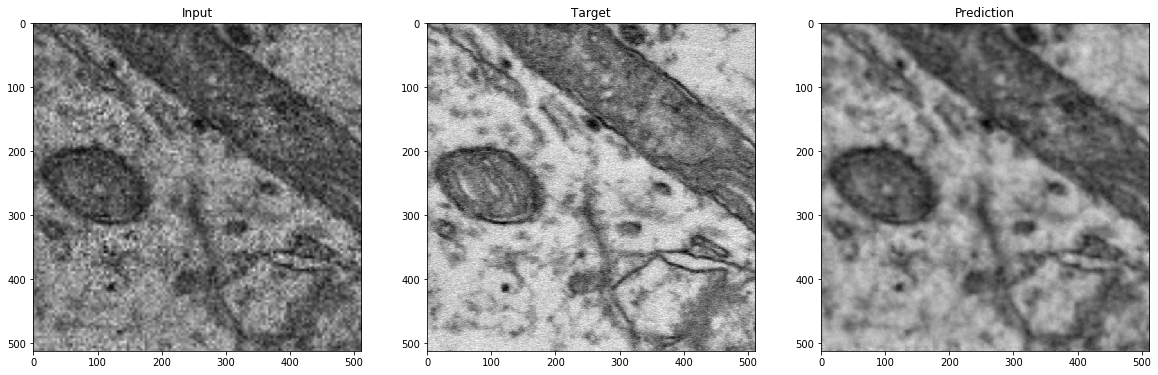

In [19]:
x, y = valid_ds[2]
x, y = x.cuda(), y.cuda()
model.eval();
pred = model(x.unsqueeze(0))
show_result(x, y, pred)

In [15]:
pred.size()

torch.Size([1, 1, 512, 512])

In [16]:
x.shape

torch.Size([3, 512, 512])

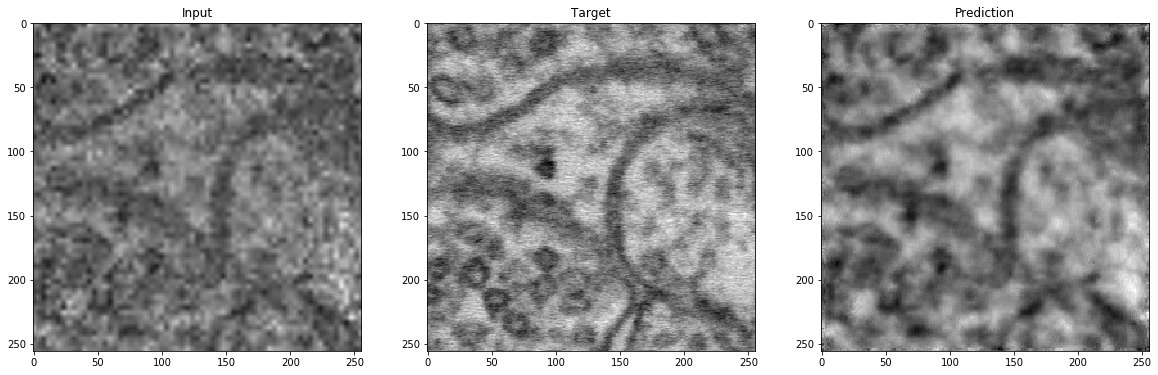

In [29]:
x, y = valid_ds[0]
x, y = x.cuda(), y.cuda()
model.eval();
pred = model(x.unsqueeze(0))
show_result(x, y, pred)

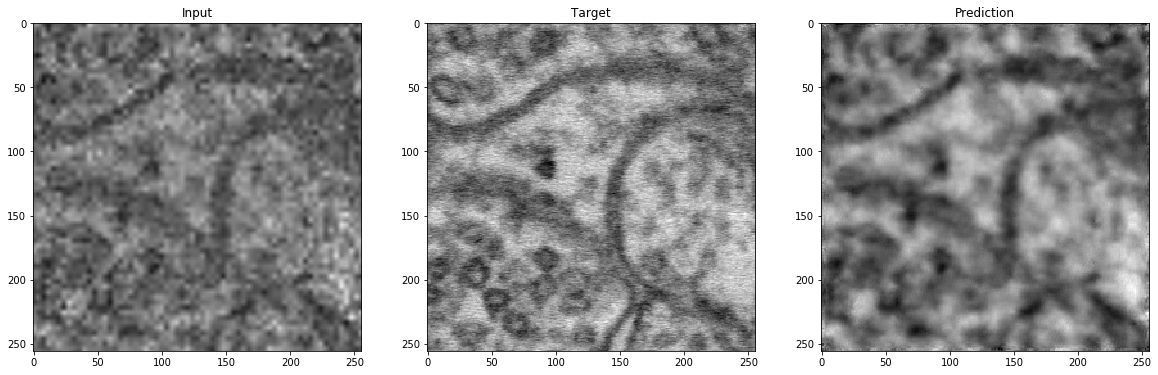

In [20]:
x, y = valid_ds[0]
x, y = x.cuda(), y.cuda()
model.eval();
pred = model(x.unsqueeze(0))
show_result(x, y, pred)

### save and export

In [20]:
model_name = 'tmp'
model_kind = 'baseline/'
model_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/models/self_sv/')
save_pth = model_pth/model_kind/(model_name+'.pkl')

In [74]:
torch.save(model.state_dict(), save_pth)